# DIABETES LEARNING



In [11]:
isGoogleColab = True

# Notes

- check these blog posts: https://muellerzr.github.io/fastblog/ and his course: https://walkwithfastai.com/intro.contribute
- learner.export() already save all the transforms that will be applied during inference time, so it is not necessary to resize or normalize stats. If running outside the model outside fastai, check: https://forums.fast.ai/t/do-we-need-to-normalize-single-image-before-running-predict-function-on-it/44301/4
- to_fp16() is mixed precision
- item_tfms already apply the resize before collating the images in a batch. So it is not necessary to do this manually
- aug_tfms will only be applied on train_dl. validation and test will not be affected
- test_dl is a testing dataloader that uses the same transforms as train_dl and valid_dl, but with new data
- check images cleaner in the future
- cross validation: check walkwithfastai video 3 or https://forums.fast.ai/t/is-it-possible-to-implement-cross-validation-in-fastai/44961/15 or https://forums.fast.ai/t/am-i-doing-k-fold-cross-validation-right/84738/6  
- stratification in Kfold and Train_Test split for Multi Label problems is not straighforward. Check http://scikit.ml/index.html#. Use for now balanced datasets!!!!



# Installation

## Kill all other GPU sessions

Run the first time this cell. Then, restart your session and run again the notebook without this code.

In [12]:
  #!kill -9 -1

## Keep Session Alive

Put this javascript code in the browser console

In [13]:
# function ClickConnect(){
#    console.log("Working");
#    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
# }  setInterval(ClickConnect,300000)

## Update ipython/ipykernel (Colab)

The Colab session can fail when running the first time this cell. Just run it a second time.

In [14]:
# This magic cell should be put first in your colab notebook. 
# It'll automatically upgrade colab's really antique ipython/ipykernel to their 
# latest versions which are required for packages like ipyexperiments 

# from packaging import version
# import IPython, ipykernel
# IPython.__version__
# if version.parse(IPython.__version__) <= version.parse("5.5.0"):
#     !pip install -q --upgrade ipython
#     !pip install -q --upgrade ipykernel
    
#     import os
#     import signal
#     os.kill(os.getpid(), signal.SIGTERM)
# print(f"ipykernel=={ipykernel.__version__}")
# print(f"IPython=={IPython.__version__}")

In [15]:
# new (large)
# !pip install ipyexperiments
# new (large)
# from ipyexperiments import IPyExperimentsPytorch
# exp = IPyExperimentsPytorch()

## Check GPU e CPU RAM

In [16]:
if isGoogleColab:
    
    import torch
    from pynvml import *
    nvmlInit()
    def log_mem():
        h = nvmlDeviceGetHandleByIndex(0)
        info = nvmlDeviceGetMemoryInfo(h)
        print(f'GPU total Memory    : {info.total}')
        print(f'GPU free Memory     : {info.free}')
        print(f'GPU Memory used     : {info.used}')
    torch.ones(1).to(0)
    log_mem()

    !nvidia-smi

GPU total Memory    : 17071734784
GPU free Memory     : 16116350976
GPU Memory used     : 955383808
Mon Jul 19 14:33:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    36W / 250W |    911MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+------------

## Mount the Google Drive to Google Colab

In [17]:
if isGoogleColab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    path_to_drive = "/content/drive/MyDrive/Colab Notebooks/"
    sys.path.append(path_to_drive + 'DevDiabetesLearning/DiabetesLearningAI') #make src files importable

else:
    path_to_drive = "./"

Mounted at /content/drive


In [18]:
#!unrar x "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/augmentedDataset_v2.rar" "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/"
#!unrar x "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/augmentedDataset.rar" # extrai local
#!unzip "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/database.zip" -d "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/"
#!wget http://www.ivl.disco.unimib.it/download/http://www.ivl.disco.unimib.it/minisites/UNIMIB2016/UNIMIB2016-images.zip -P /content/drive/MyDrive/UnB/TCC/DevDiabetesLearning/DiabetesLearningAI/dataset_UNIMIB
#!unzip "/content/drive/MyDrive/UnB/TCC/DevDiabetesLearning/DiabetesLearningAI/dataset_UNIMIB/UNIMIB2016-images.zip" -d "/content/drive/MyDrive/UnB/TCC/DevDiabetesLearning/DiabetesLearningAI/dataset_UNIMIB/"

## Install Deep Learning libraries

In [19]:
# !pip install torch
# !pip install fastai==2.4.1
# !pip install wandb

##restart runtime!!!

In [20]:
import sys; print('Python:',sys.version)
import torch; print('Pytorch:',torch.__version__)
import fastai; print('Fastai:',fastai.__version__)

Python: 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
Pytorch: 1.9.0+cu102
Fastai: 2.4.1


# Train your model

In [21]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.callback.wandb import *
import torch
import torchvision
from PIL import Image
import wandb
wandb.login()

wandb: Currently logged in as: bunoviske (use `wandb login --relogin` to force relogin)


True

## Data

In [22]:
path = path_to_drive + 'DevDiabetesLearning/DiabetesLearningAI/dataset_PE_Brazilian_Foods/' 

path_img_val = path + '/done/train_val/val/'
path_img_test = path + '/done/test/'

path_img = path + "done/train_val/"
path_anno = path + "gt/"

#funcao que pega a imagem de anotacoes correspondente, dado a imagem original de entrada
get_y_fn = lambda x : path_anno + '/' + x.parent.stem + "_ann/" + f'{x.stem}.png'

In [23]:
np.random.seed(2) #mesma semente para todas as vezes que executar
randomSeed = 2

label_fnames = get_image_files(path_anno)
print(label_fnames[:3])
fnames = get_image_files(path_img)
print(fnames[:3])

len(fnames), len(label_fnames)

[Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_PE_Brazilian_Foods/gt/test_ann/apple_102.png'), Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_PE_Brazilian_Foods/gt/test_ann/apple_101.png'), Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_PE_Brazilian_Foods/gt/test_ann/apple_100.png')]
[Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_PE_Brazilian_Foods/done/train_val/val/apple_9.png'), Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_PE_Brazilian_Foods/done/train_val/val/apple_11.png'), Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_PE_Brazilian_Foods/done/train_val/val/apple_12.png')]


(1000, 1250)

In [24]:
codes = np.loadtxt(path + 'classesNumber.txt', dtype=str, delimiter='\n',encoding='utf')
codes = list(codes)
len(codes)

11

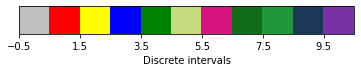

In [25]:
# define colormap for masks

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = matplotlib.colors.ListedColormap([np.random.rand(3,) for i in range(0,len(codes))])
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.75, .75, .75, 1.0) # nao alimento -> cinza
cmaplist[1] = "red" # nao registrado
cmaplist[2] = "yellow" #arroz integral
cmaplist[3] = "blue" #arroz branco
cmaplist[4] = "green" #feijao

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = [i-0.5 for i in range(0,len(codes)+1)] # intervalos devem conter apenas o numero inteiro, entao ir de 0.5 em 0.5
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

cb2 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Discrete intervals')
fig.show()

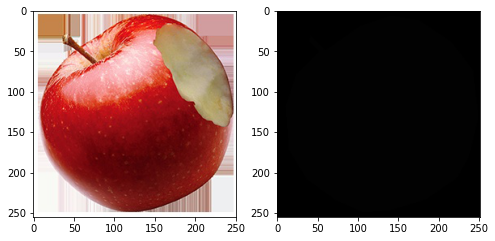

Ground truth Codes [0 2]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_PE_Brazilian_Foods/done/train_val/train/apple_15.png


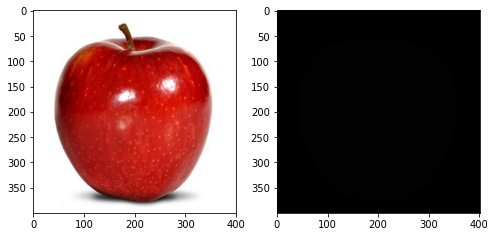

Ground truth Codes [0 2]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_PE_Brazilian_Foods/done/train_val/train/apple_14.png


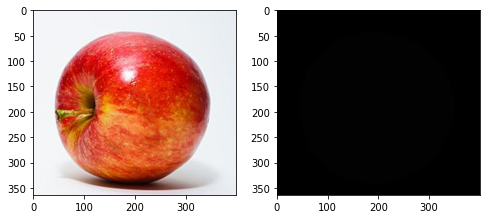

Ground truth Codes [0 2]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_PE_Brazilian_Foods/done/train_val/train/apple_13.png


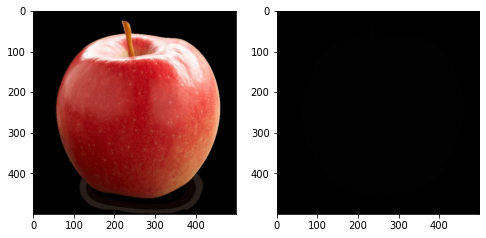

Ground truth Codes [0 2]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_PE_Brazilian_Foods/done/train_val/train/apple_18.png


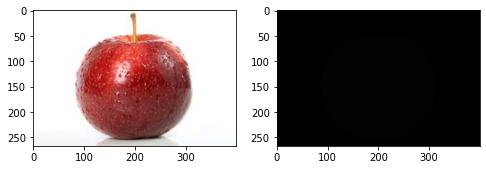

Ground truth Codes [0 2]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_PE_Brazilian_Foods/done/train_val/train/apple_16.png


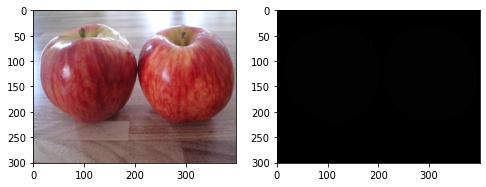

Ground truth Codes [0 2]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_PE_Brazilian_Foods/done/train_val/train/apple_17.png


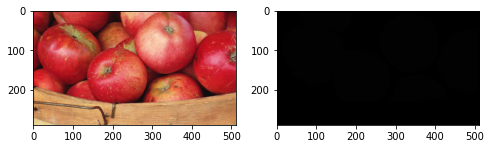

Ground truth Codes [0 2]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_PE_Brazilian_Foods/done/train_val/train/apple_22.png


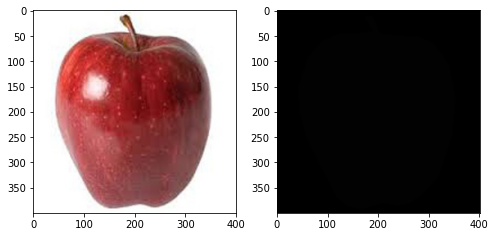

Ground truth Codes [0 2]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_PE_Brazilian_Foods/done/train_val/train/apple_25.png


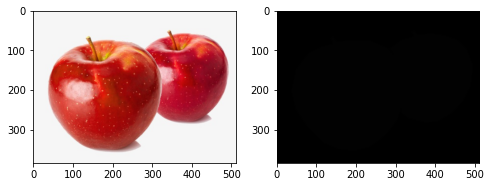

Ground truth Codes [0 2]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_PE_Brazilian_Foods/done/train_val/train/apple_23.png


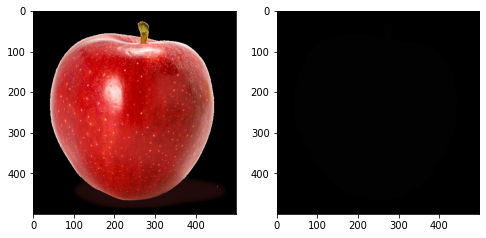

Ground truth Codes [0 2]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_PE_Brazilian_Foods/done/train_val/train/apple_26.png


In [26]:
### VISUALIZACAO DA MÁSCARA FICA COM A BORDA ESTRANHA, MAS ELA ESTÁ CORRETA COMO PODE SER VISTO NOS CODIGOS DO GROUND TRUTH
start = 260
for idx in range(start,start+10):
  fig = plt.figure(figsize=(8,8))

  img = Image.open(fnames[idx])
  arr = np.asarray(img)
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(arr)

  #img1 = get_y_fn_adjusted(fnames[idx]) # use this when 'adjustedGroundTruthIds' is necessary
  img1 = Image.open(get_y_fn(fnames[idx])).convert("RGB")
  arr = np.asarray(img1)
  ax1 = fig.add_subplot(1,2,2)
  ax1.imshow(arr, cmap=cmap, norm=norm)
  plt.show()

  print("Ground truth Codes", np.unique(arr,return_counts=False))
  print(fnames[idx])


## Data Augmentation

In [27]:
size = (256, 256)
item_tfms = [Resize(size, method=ResizeMethod.Squish, resamples=(Image.NEAREST,Image.NEAREST))]
aug_tfms = aug_transforms(mult=1, flip_vert=True, size=size)

## Dataloaders

In [28]:
# dataset balance method. choose one of them or none

lossClassWeights = None
sampler = None

#### load class weights from pickle ####
# with open( path + "classWeightsSprint1.pkl", 'rb') as f:
#   weights = pickle.load(f)
# classWeights = torch.FloatTensor(weights).cuda() 

#### assign class weights empirically ####
# classWeights = torch.ones(len(codes)).cuda()
# classWeights[0] = 0.1

### 1. class weights in loss function ###
# lossClassWeights = classWeights

### 2. oversampling ### not yet implemented, check here https://forums.fast.ai/t/oversampling-in-fastai2/73721/14

# sampler = torch.utils.data.sampler.WeightedRandomSampler(classWeights, len(classWeights))                     
# total_len_oversample = int(learn.data.c*np.max(label_counts))
# dataloaders.train_dl.dl.batch_sampler = BatchSampler(WeightedRandomSampler(weights,total_len_oversample), data.train_dl.batch_size,False)

In [29]:
# get data split from files or function

#### split train/test randomly ####
#from sklearn.model_selection import train_test_split
#X_train, X_test, _, _ = train_test_split(fnames, label_fnames, test_size=0.2, random_state=randomSeed, shuffle=True, stratify=None)

#### split by validation folder ####
X_val = get_image_files(path_img_val)

#### split by test folder ####
X_test = get_image_files(path_img_test)

In [30]:
X_val, X_test

((#250) [Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_PE_Brazilian_Foods/done/train_val/val/apple_9.png'),Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_PE_Brazilian_Foods/done/train_val/val/apple_11.png'),Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_PE_Brazilian_Foods/done/train_val/val/apple_12.png'),Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_PE_Brazilian_Foods/done/train_val/val/apple_19.png'),Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_PE_Brazilian_Foods/done/train_val/val/apple_20.png'),Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_PE_Brazilian_Foods/done/train_val/val/apple_31.png'),Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_PE_Brazilian_Foods/done/train_

In [53]:
bs = 8 # batch size
gradientAcc = int(32/bs) # 32 is the final "batch size"

trainBlock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FuncSplitter(lambda o: o in X_val),
                   get_y=get_y_fn,
                   item_tfms=item_tfms, 
                   batch_tfms=[*aug_tfms, Normalize.from_stats(*imagenet_stats)])

dataloaders = trainBlock.dataloaders(path_img, path=path, bs=bs)

#### test dataloader #### 
#### it is not working!!!!!!! test_dl always gives the same result

# testBlock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
#                    get_items=get_image_files,
#                    splitter=FuncSplitter(lambda o: o in X_test),
#                    get_y=get_y_fn,
#                    item_tfms=item_tfms, 
#                    batch_tfms=[Normalize.from_stats(*imagenet_stats)])
# testDataloaders = testBlock.dataloaders(path_img, path=path, bs=bs)

test_dl = dataloaders.test_dl(X_test, with_labels=True)
test_dl.vocab = codes

In [54]:
len(dataloaders.train_ds), len(dataloaders.valid_ds), len(test_dl.dataset)

(750, 250, 250)

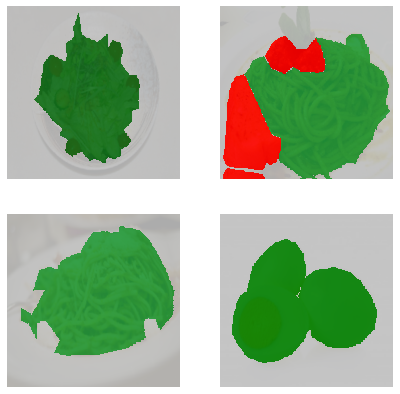

In [55]:
dataloaders.train.show_batch(max_n=4, figsize=(7, 7), cmap=cmap, norm=norm,alpha=0.9)

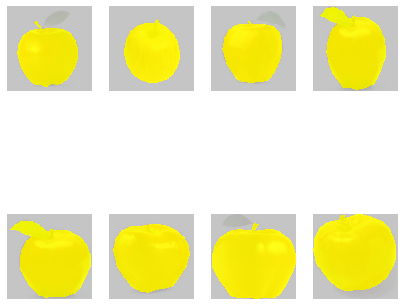

In [56]:
dataloaders.valid.show_batch(max_n=8, figsize=(7, 7), cmap=cmap, norm=norm,alpha=0.9)

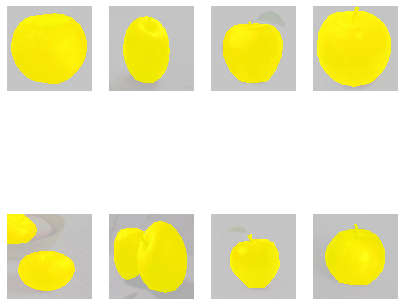

In [57]:
test_dl.show_batch(max_n=8, figsize=(7, 7), cmap=cmap, norm=norm,alpha=0.9)

## Metrics

In [58]:
from fastaiMetrics import acc_segmentation, MIOU

classes_index = range(1, len(codes)) #exclude background class at index 0
metrics = [acc_segmentation, DiceMulti, MIOU(classes_index, axis=1)]

## Model

In [67]:
class CombinedLoss():
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1., alpha=1.):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth)        

    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

class CombinedLossTunable(Module):
    "Dice and Focal combined with Tunable Parameter"
    def __init__(self, axis=1, smooth=1.):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth)

        self.numLosses = 2
        self.log_vars = nn.Parameter(torch.zeros((self.numLosses)))        

    def forward(self, pred, targ):

        loss0 = self.focal_loss(pred, targ)
        loss1 = self.dice_loss(pred, targ)
      
        precision0 = torch.exp(-self.log_vars[0])
        loss0 = precision0*loss0 + self.log_vars[0]

        precision1 = torch.exp(-self.log_vars[1])
        loss1 = precision1*loss1 + self.log_vars[1]

        return loss0 + loss1
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [69]:
# EarlyStoppingCallback(monitor='miou',patience=50) -> if patience is too high, this may cause error in learner.validate()
modelCallbacks = [ShowGraphCallback]
opt_func = Adam

# loss_func = CrossEntropyLossFlat(weight=lossClassWeights, axis=1)
# loss_func = FocalLossFlat(weight=lossClassWeights, axis=1)
loss_func = CombinedLossTunable()

learner = unet_learner(dataloaders, resnet34, loss_func=loss_func, opt_func=opt_func, metrics=metrics, cbs=modelCallbacks,
                       self_attention=False, act_cls=Mish).to_fp32()

In [41]:
#learner.model[0].load_state_dict(torch.load(path_to_drive + 'DiabetesLearning/trainingConfig/resnet34_encoder-food101.h5'), strict=True); #load preTrained from FOOD101

In [39]:
# learner.load(path + 'stage-2-brazilFoods', strict=False)
# learner.load_state_dict(torch.load(path + 'stage-2-brazilFoods.pth'), strict=False)
# learner.model.load_state_dict(torch.load(path + 'stage-2-brazilFoods.pth'), strict=False)
# test = Learner(dataloaders,resnet34)
# learner.load('stage-1-best')

## Training

SuggestedLRs(valley=9.120108734350652e-05)

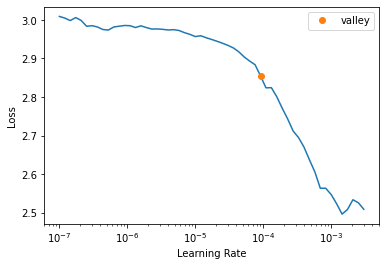

In [71]:
learner.lr_find()

In [72]:
lr = 3e-4
freezeEpochs = 10
unfreezeEpochs = 20
wd = 1e-2
learner.freeze()

epoch,train_loss,valid_loss,acc_segmentation,dice_multi,miou,time
0,1.893918,1.240634,0.286061,0.312094,0.292568,00:39
1,1.117266,0.705575,0.655339,0.635339,0.583625,00:40
2,0.733906,0.672780,0.700541,0.694656,0.626998,00:39
3,0.596833,0.447192,0.762784,0.756866,0.749954,00:39
4,0.575138,0.356850,0.837764,0.797827,0.786781,00:39
5,0.503965,0.463734,0.803003,0.738156,0.690328,00:39
6,0.574267,0.387605,0.851379,0.800124,0.783196,00:40
7,0.481444,0.535273,0.768054,0.754289,0.732270,00:39
8,0.483075,0.386528,0.821090,0.782498,0.757092,00:40
9,0.474748,0.413467,0.817874,0.770582,0.746323,00:40


Better model found at epoch 0 with miou value: 0.2925679966650866.


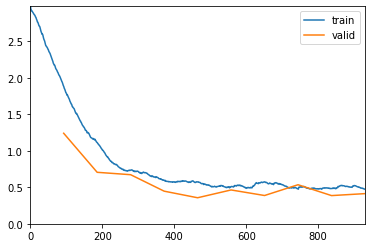

Better model found at epoch 1 with miou value: 0.5836251958698114.
Better model found at epoch 2 with miou value: 0.6269976031721275.
Better model found at epoch 3 with miou value: 0.7499542718593817.
Better model found at epoch 4 with miou value: 0.7867806412734198.


epoch,train_loss,valid_loss,acc_segmentation,dice_multi,miou,time
0,0.429213,0.349560,0.844913,0.795364,0.772143,00:45
1,0.386659,0.368101,0.811269,0.805157,0.810192,00:40
2,0.386454,0.328734,0.867689,0.820908,0.803017,00:40
3,0.411533,0.368925,0.820189,0.796697,0.787525,00:41
4,0.383961,0.322528,0.826263,0.826584,0.829808,00:40
5,0.372981,0.369776,0.839141,0.793952,0.780198,00:41
6,0.371635,0.342067,0.854798,0.831065,0.814309,00:41
7,0.307804,0.351073,0.860880,0.841309,0.836242,00:41
8,0.294426,0.331625,0.877796,0.836406,0.827573,00:40
9,0.266350,0.297368,0.865586,0.845249,0.839270,00:40


Better model found at epoch 0 with miou value: 0.7721426150928486.


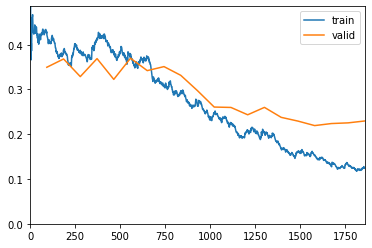

Better model found at epoch 1 with miou value: 0.8101924044716077.
Better model found at epoch 4 with miou value: 0.8298081528499551.
Better model found at epoch 7 with miou value: 0.8362421193401646.
Better model found at epoch 9 with miou value: 0.8392700897201572.
Better model found at epoch 10 with miou value: 0.8589628495590823.
Better model found at epoch 11 with miou value: 0.8722845476810548.
Better model found at epoch 13 with miou value: 0.8770789306558274.
Better model found at epoch 14 with miou value: 0.8806265131942622.
Better model found at epoch 15 with miou value: 0.8823108482878231.
Better model found at epoch 16 with miou value: 0.8888221125338346.
Better model found at epoch 17 with miou value: 0.8896253817600753.


epoch,30
train_loss,0.12414
raw_loss,0.06334
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,1e-05
wd_1,0.01
sqr_mom_1,0.99
lr_1,0.0


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▆▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▄▅▂▃▃▅▃▃▃▃▂▃▂▂▂▂▂▂▃▂▂▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▂▃▄▅▅▆▇▇██▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mom_0,██▇▇▆▅▅▄▃▂▂▁▁▆█▇▆▄▃▂▁▁▁▁▁▂▂▃▃▄▅▅▆▆▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▁▂▂▃▄▅▅▆▇▇██▃▂▂▃▃▄▄▄▅▅▄▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁


In [73]:
run = wandb.init(project="diabetesLearning-peBrazilianFoods") # track machine learning experiment
fitCallbacks = [WandbCallback(log='all'), SaveModelCallback(every_epoch=False, monitor='miou', fname='stage-1-combinedLossTunable',with_opt=True), GradientAccumulation(n_acc=gradientAcc)]
# learner.fit_one_cycle(epochs, slice(lr), pct_start=0.8, wd=wd, cbs=fitCallbacks)
# learner.fit_flat_cos(epochs, slice(lr), wd=wd,cbs=fitCallbacks)
learner.fine_tune(unfreezeEpochs, base_lr=lr, freeze_epochs=freezeEpochs, pct_start=0.3, wd=wd, cbs=fitCallbacks)
run.finish()

## Fine-tunning (optional)

In [ ]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()

In [ ]:
# learner = unet_learner(dataloaders, resnet34, loss_func=CrossEntropyLossFlat(axis=1), metrics=metrics, cbs=callbacks,
#                        wd_bn_bias=True).to_fp16()
# learner.load('stage-1-best')


In [ ]:
learner.unfreeze()
# learner.lr_find()

In [ ]:
lrs = slice(lr/400,lr/4)
epochs = 50
wd = 1e-2

epoch,train_loss,valid_loss,acc_segmentation,dice_multi,miou,time
0,0.443479,0.832528,0.532327,0.256014,0.118144,02:15
1,0.419501,0.806147,0.544782,0.271664,0.126363,02:14
2,0.403940,0.828603,0.533374,0.258908,0.119813,02:15
3,0.397915,0.831908,0.537469,0.274561,0.128003,02:15
4,0.402978,0.828310,0.528577,0.270263,0.125514,02:15
5,0.376559,0.835561,0.534543,0.280300,0.130349,02:14
6,0.383563,0.833254,0.534618,0.282890,0.132608,02:16
7,0.342848,0.858938,0.526259,0.275354,0.127085,02:15
8,0.356883,0.832172,0.540758,0.299238,0.140044,02:15
9,0.331411,0.850221,0.529885,0.289319,0.134324,02:16


/content/drive/My Drive/Colab Notebooks/DiabetesLearning/fastaiMetrics.py:39: RuntimeWarning: invalid value encountered in true_divide
  iou_index = per_class_TP / (per_class_TP + per_class_FP + per_class_FN)


Better model found at epoch 0 with acc_segmentation value: 0.5323270559310913.


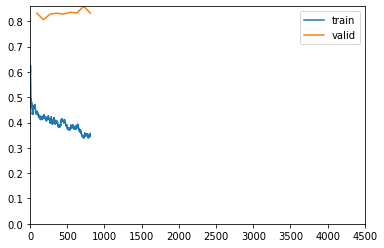

Better model found at epoch 1 with acc_segmentation value: 0.5447819232940674.
No improvement since epoch 1: early stopping


epoch,46
train_loss,0.33141
raw_loss,0.16842
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,0.0
beta_0,0.0
wd_1,0.01
sqr_mom_1,0.99


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▆▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,▇█▅▅▅▄▅▄▄▃▄▃▃▃▂▂▃▃▄▂▂▃▃▂▂▂▃▂▂▂▃▂▁▁▂▂▁▂▂▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,███████████████████████████████▁▁▁▁▁▁▁▁▁
mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [ ]:
#run = wandb.init(project="diabetesLearning") # track machine learning experiment
fitCallbacks = [WandbCallback(log='all'), SaveModelCallback(every_epoch=False, monitor='acc_segmentation', fname='stage-2-best',with_opt=True),GradientAccumulation(n_acc=gradientAcc)]
# learner.fit_one_cycle(epochs, lrs, pct_start=0.3, wd=wd, cbs=fitCallbacks)
learner.fit_flat_cos(epochs, lrs, wd=wd, cbs=fitCallbacks)
run.finish()

In [ ]:
# learner.load('stage-2-best')
# learner.save('stage-2-size350-bestEpoch')

## FastAI Validation

In [74]:
id2name = {k:v for k,v in enumerate(codes)} # faz uma lista que relaciona nome e id

#### fastai metrics names
metricsNames = ["Loss", "Acc_Segmentation", "Dice", "Miou"]

#### add iou per class if you want
from fastaiMetrics import IOU
iouPerClass = []
for x in range(1,len(codes)): iouPerClass.append(IOU(x, codes[x], axis=1, ignore_index=0)) #ignore background idx 0
learner.metrics = metrics + iouPerClass
metricsNames += ["Iou " + codes[x] for x in range(1,len(codes))]

#### LOAD ONLY IF NECESSARY
# learner = unet_learner(dataloaders, resnet34, metrics=metrics+iouPerClass)
# learner.load('stage-1-combinedLoss')

In [44]:
#### check if model overfits ####
# trainset = tuple(zip(metricsNames,learner.validate(dl=dataloaders.train)))

#### validate validset ####
validset = tuple(zip(metricsNames,learner.validate(dl=dataloaders.valid)))

# "Trainset", trainset
"Validset", validset

('Validset',
 (('Loss', 0.10230681300163269),
  ('Acc_Segmentation', 0.8975199460983276),
  ('Dice', 0.8886351658379105),
  ('Miou', 0.8840726394030373),
  ('Iou NaoRegistrado', 0.4361246089038821),
  ('Iou Apple', 0.9878347676331942),
  ('Iou Bean', 0.9201324102707608),
  ('Iou Boiled Egg', 0.8289207530372947),
  ('Iou Chicken Breast', 0.7682273210105235),
  ('Iou Rice', 0.8755844175608442),
  ('Iou Salad', 0.8858932038483927),
  ('Iou Spaghetti', 0.932236382458299),
  ('Iou Fried Egg', 0.945495629681835),
  ('Iou Steak', 0.8248722239102122)))

In [75]:
#### validate testset ####
# learner.dls.valid = test_dl
testset = tuple(zip(metricsNames,learner.validate(dl=test_dl)))
"Testset", testset

('Testset',
 (('Loss', 0.2638300955295563),
  ('Acc_Segmentation', 0.8899083733558655),
  ('Dice', 0.8530885417568115),
  ('Miou', 0.8473377744903885),
  ('Iou NaoRegistrado', 0.23399345517215858),
  ('Iou Apple', 0.9908765311599544),
  ('Iou Bean', 0.8858465660965932),
  ('Iou Boiled Egg', 0.8433009171965061),
  ('Iou Chicken Breast', 0.7071481599321243),
  ('Iou Rice', 0.9109849105132958),
  ('Iou Salad', 0.882478845950078),
  ('Iou Spaghetti', 0.9515061108843375),
  ('Iou Fried Egg', 0.8742876237108382),
  ('Iou Steak', 0.8427453911310414)))

In [49]:
# dl = dataloaders.valid
dl = test_dl

/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/fastaiMetrics.py:39: RuntimeWarning: invalid value encountered in true_divide
  iou_index = per_class_TP / (per_class_TP + per_class_FP + per_class_FN)


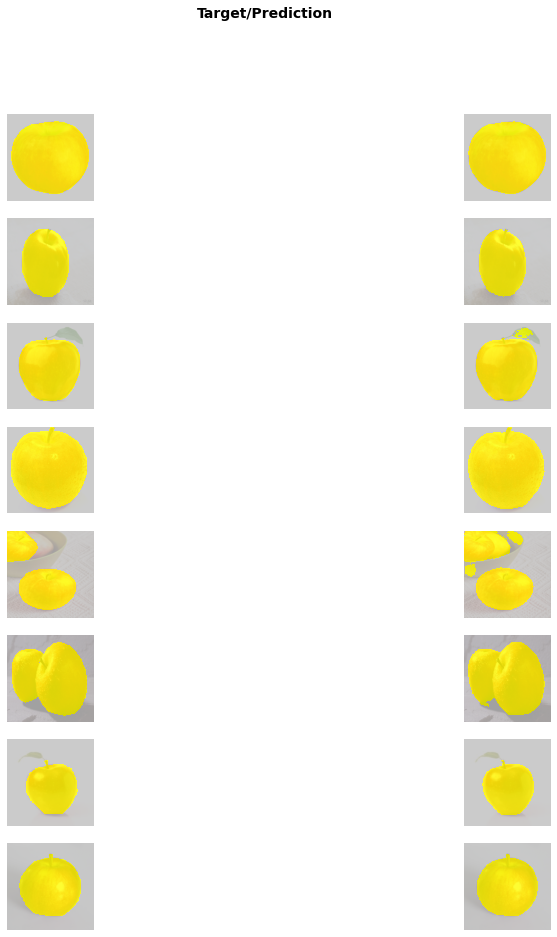

In [50]:
learner.show_results(dl=dl, figsize=(15,15), max_n=40, cmap=cmap, norm=norm,alpha=0.8)

In [ ]:
# interp = Interpretation.from_learner(learner, dl=test_dl)
# losses,idxs = interp.top_losses()
# interp.plot_top_losses(4, figsize=(15,11), cmap=cmap, norm=norm)

In [ ]:
#interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
#interp.most_confused(min_val=10)

## Sklearn Validation

In [46]:
from sklearnMetrics import Metrics
void_code = 0
metricsObject = Metrics(codes, [void_code])
id2name = {k:v for k,v in enumerate(codes)} # faz uma lista que relaciona nome e id

# LOAD ONLY IF NECESSARY
# learner = unet_learner(dataloaders, resnet34, metrics=metrics)
# learner.load('stage-1-best')

In [47]:
#input, probabilities, groundTruth, decoded, losses = learner.get_preds(dl=dl,  with_input=True, with_loss=True, with_decoded=True, act=F.softmax) #inputs, preds, groundTruth, losses
input, probabilities, groundTruth, decoded = learner.get_preds(dl=dl,  with_input=True, with_loss=False, with_decoded=True, act=F.softmax) #inputs, preds, groundTruth, losses

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ret = func(*args, **kwargs)


In [48]:
print(metricsObject.getAccuracy(decoded.flatten().numpy(), groundTruth.flatten().numpy()))

0.7354240296561582


In [43]:
print(metricsObject.get_f1Score(decoded.flatten().numpy(), groundTruth.flatten().numpy()))

0.8858452068152022


In [44]:
confusionMatrix = metricsObject.getConfusionMatrix(decoded.flatten().numpy(), groundTruth.flatten().numpy(), plot=False)

In [ ]:
mostConfused = metricsObject.mostConfused(confusionMatrix, numberOfConfusions=4)

print("Actual", "   Predicted", "   Wrong pixels\n")
mostConfused

Actual    Predicted    Wrong pixels



[['Chicken Breast', 'Steak', 177349],
 ['Salad', 'NaoRegistrado', 65988],
 ['Chicken Breast', 'Rice', 58244],
 ['Steak', 'Bean', 56420]]

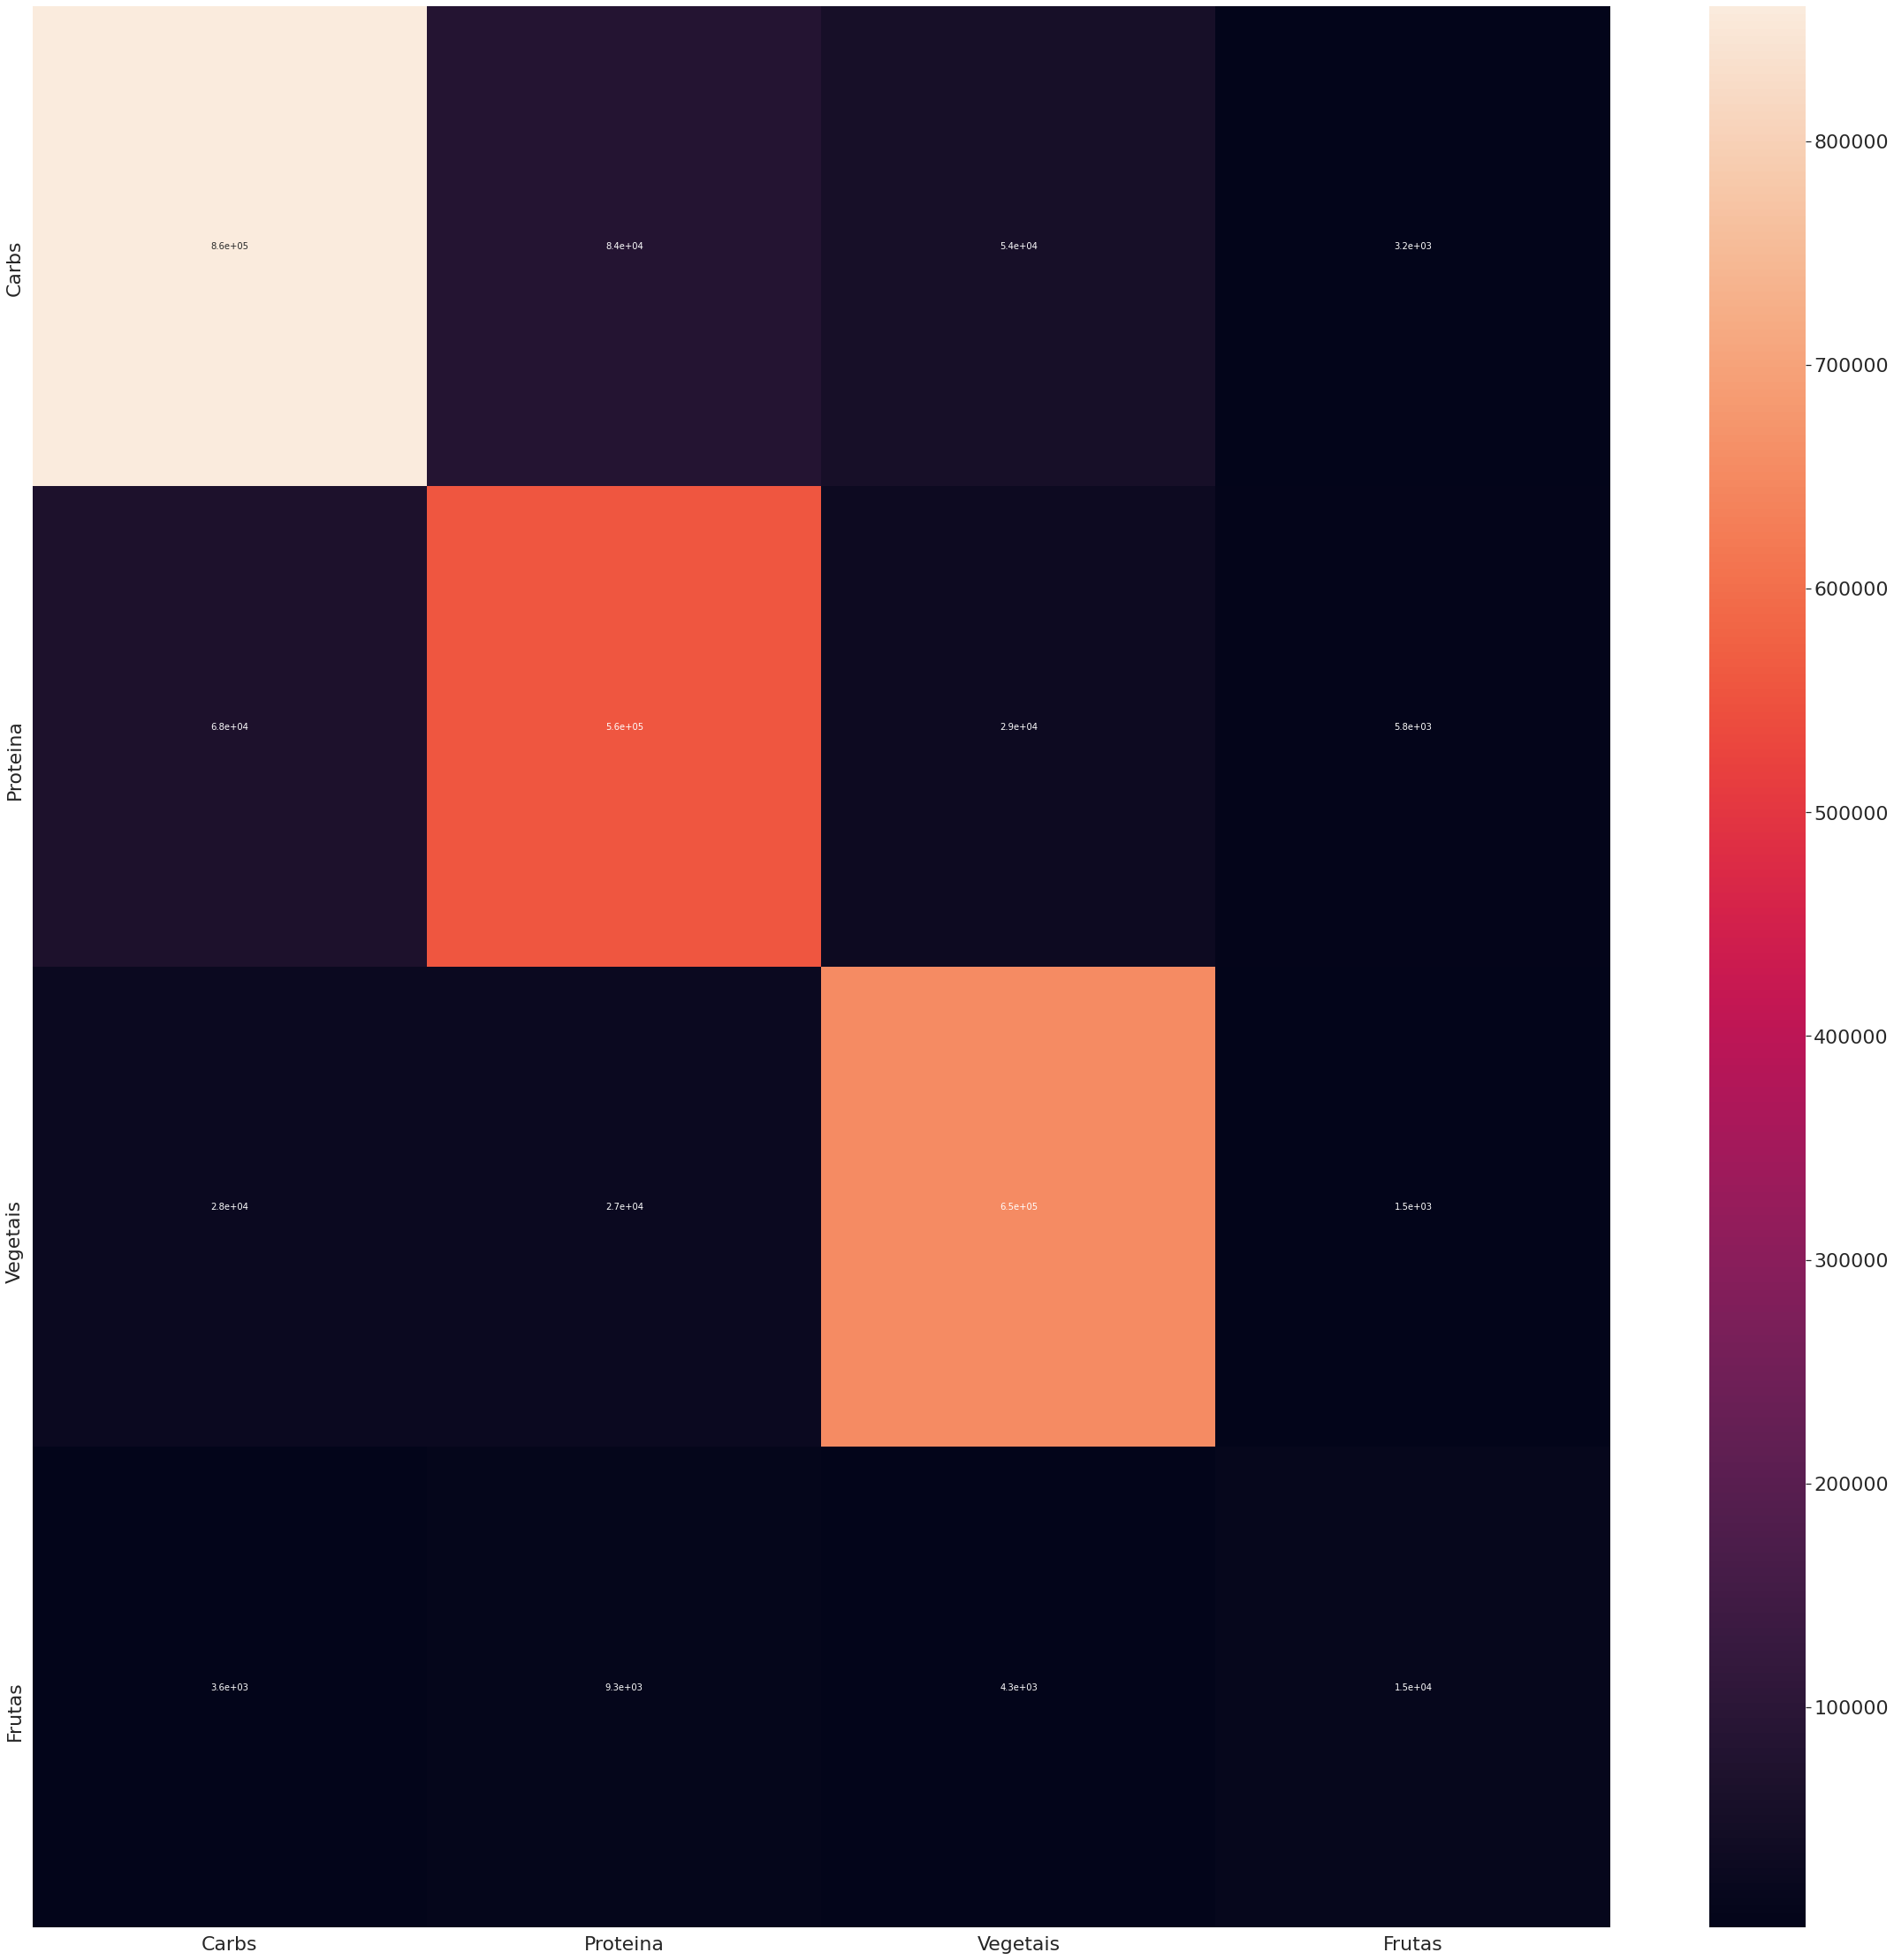

In [ ]:
#plot confusion matrix (take some time, too big the matrix). Think in a better way to visualize (check for most confuseds)

metricsObject.plotConfusionMatrix(confusionMatrix, font_scale=2, removeDiagonal=False)

In [49]:
print(metricsObject.getClassificationReport(decoded.flatten().numpy(), groundTruth.flatten().numpy()))

                precision    recall  f1-score   support

 NaoRegistrado       0.22      0.23      0.22    266977
         Apple       0.99      0.96      0.98    728412
          Bean       0.79      0.83      0.81    910187
    Boiled Egg       0.84      0.85      0.84    484520
Chicken Breast       0.90      0.20      0.33    485532
          Rice       0.72      0.83      0.77    881665
         Salad       0.94      0.55      0.69    944606
     Spaghetti       0.95      0.88      0.91    994755
     Fried Egg       0.94      0.82      0.88    562471
         Steak       0.72      0.74      0.73    743805

     micro avg       0.82      0.74      0.78   7002930
     macro avg       0.80      0.69      0.72   7002930
  weighted avg       0.84      0.74      0.76   7002930



## Check some particular image details

In [ ]:
from collections import OrderedDict

id2name = {k:v for k,v in enumerate(codes)} # faz uma lista que relaciona nome e id

def getFoodsInImage(tensor, removeVoid=False):
    foods, counts = np.unique(tensor,return_counts=True)
    if removeVoid:
        counts = np.delete(counts, 0) #tira o void na posicao 0 do array
        foods = np.delete(foods, 0) #tira o void na posicao 0 do array
    
    foodNames = []
    print(f'Numero de alimentos: {len(foods)}')
    for food in foods:
        foodNames = np.append(foodNames,id2name[food])
    dictCounts = dict(zip(foodNames, counts))
    dictCounts = OrderedDict(sorted(dictCounts.items(), key=lambda x: x[1], reverse=True))
    print(dictCounts)
    return dictCounts

def getMostAppearances(foodCountsDict, k = 3):
    sortedDict = OrderedDict(sorted(foodCountsDict.items(), key=lambda x: x[1], reverse=True))
    topKDict = {}
    for count, (key, v) in enumerate(foodCountsDict.items()):
        if count == k:
            break
        elif key != "NaoAlimento":
            topKDict[key] = v
        else:
            k += 1 # increment k if find NaoAlimento in the first positions
    
    return topKDict
        


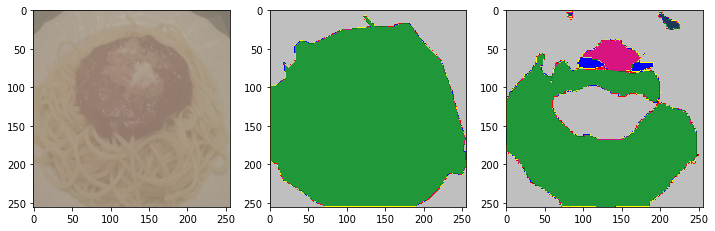

In [ ]:
idx = 200
fig = plt.figure(figsize=(12,12))

# denorm to original image
rawImage = copy(input[idx])

nrm = Normalize.from_stats(*imagenet_stats)
image = nrm.decode(rawImage) #fastai version 2.3.1 needs two denorms!!!! FUCK YOU FASTAI!!!
image = nrm.decode(image).clamp(0,1).squeeze().permute(1,2,0) # denorm image from imagenet stats

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(image)

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(groundTruth[idx], cmap=cmap, norm=norm)

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(decoded[idx], cmap=cmap, norm=norm)

In [ ]:
print("Ground truth\n")
sample = groundTruth[idx]
gtDictCounts = getFoodsInImage(sample)


Ground truth

Numero de alimentos: 2
OrderedDict([('Spaghetti', 48965), ('NaoAlimento', 16571)])


In [ ]:
print("Prediction\n")
sample = decoded[idx]
decodedDictCounts = getFoodsInImage(sample)


Prediction

Numero de alimentos: 6
OrderedDict([('NaoAlimento', 32948), ('Spaghetti', 29646), ('Rice', 1888), ('Bean', 645), ('Fried Egg', 301), ('NaoRegistrado', 108)])


In [ ]:
# get low prob classes

bestProbs, bestProbsIdx = torch.max(probabilities[idx], dim=0)
lowProbs = []
lowProbsIdx = []

mask = bestProbs < 0.5
lowProbsIdx = bestProbsIdx[mask]
lowProbDictCounts = getFoodsInImage(lowProbsIdx)

print("\nPercentual de pixeis com baixa probabilidade\n")
for key, value in lowProbDictCounts.items():
    pct = float(value/decodedDictCounts[key]*100)
    print(key, '{:.2f}'.format(pct), "%" )

Numero de alimentos: 6
OrderedDict([('NaoAlimento', 1401), ('Spaghetti', 1040), ('Rice', 972), ('Bean', 644), ('NaoRegistrado', 108), ('Fried Egg', 81)])

Percentual de pixeis com baixa probabilidade

NaoAlimento 4.25 %
Spaghetti 3.51 %
Rice 51.48 %
Bean 99.84 %
NaoRegistrado 100.00 %
Fried Egg 26.91 %


In [ ]:
# get high prob classes

bestProbs, bestProbsIdx = torch.max(probabilities[idx], dim=0)

mask = bestProbs > 0.5
highProbsIdx = bestProbsIdx[mask]
highProbDictCounts = getFoodsInImage(highProbsIdx)

print("\nPercentual de pixeis com alta probabilidade\n")
for key, value in highProbDictCounts.items():
    pct = float(value/decodedDictCounts[key]*100)
    print(key, '{:.2f}'.format(pct), "%" )

Numero de alimentos: 5
OrderedDict([('Carbs', 24024), ('NaoAlimento', 18602), ('Proteina', 11822), ('Vegetais', 6995), ('Frutas', 80)])

Percentual de pixeis com alta probabilidade

Carbs 93.36 %
NaoAlimento 96.87 %
Proteina 89.98 %
Vegetais 96.39 %
Frutas 39.02 %


## Predictions of new input data

In [ ]:
# always load it!

learner = unet_learner(dataloaders, resnet34, self_attention=False, act_cls=Mish)
learner.load('stage-1-best')

In [ ]:
#input should be a PIL object

index = 50
img = dataloaders.valid_ds[index][0]

# img_pil = Image.open("3.jpg")
# img = np.asarray(img_pil.resize((400,400)))

pred = learner.predict(img)

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(pred[0],cmap=cmap)

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img)

foods = getFoodsInImage(pred[0])
k = 3
mostAppear = list(getMostAppearances(foods, k=k).keys())
print('\n{} principais alimentos:'.format(k),mostAppear)

## REMOVE THIS LATER (TOMAS)

In [ ]:
from sklearn.preprocessing import label_binarize

mask = groundTruth.unsqueeze(dim=1)!=0
gtOneHotEncoded = label_binarize(groundTruth.flatten().numpy(), classes=range(len(codes)))

# groundTruthIgnoringBackground = groundTruth[mask.squeeze()]
# gtOneHotEncoded = label_binarize(groundTruthIgnoringBackground.flatten().numpy(), classes=range(len(codes)))

# probabilitiesIgnoringBackground = probabilities[mask.unsqueeze(dim=1)]
probabilities = probabilities.reshape((-1,16,256*256))
probabilities = probabilities.permute(0,2,1)
probabilities = probabilities.reshape((-1,16))

flatMask = mask.flatten()
# probabilitiesIgnoringBackground = np.array([Tensor(probabilities[i,:]) for i in range(len(flatMask[:100000])) if flatMask[i] == True])
# probabilitiesIgnoringBackground = probabilities[mask.flatten().unsqueeze(dim=1)]

flatMask.shape, probabilities.shape, gtOneHotEncoded.shape

(torch.Size([5636096]), torch.Size([5636096, 16]), (5636096, 16))

In [ ]:
# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(gtOneHotEncoded.ravel(), probabilities.ravel())
roc_auc = auc(fpr, tpr)

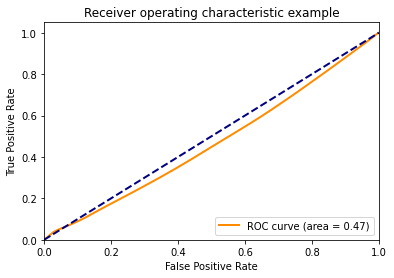

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()